<a href="https://colab.research.google.com/github/kbpavan/Text-Analytics-on-Food.com-Recipes-Review-Data-/blob/master/Copy_of_Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5975 sha256=8395a6453563b33cb29e3cabb807b78806474fafa6663e97f45397849b7364bd
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from  xgboost import XGBClassifier


from apyori import apriori
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from bs4 import BeautifulSoup

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle

from tqdm import tqdm
import os

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**Reading the data**

In [0]:
Recipes = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Food_Data/RAW_recipes.csv')
Interactions  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Food_Data/RAW_interactions.csv')


**Let's look at Interactions Data**

In [7]:
Interactions.head(n=5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


**Now Let's look at recipes Data**

In [8]:
Recipes.head(n=5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


**Joining Interations data with the original recipe data**

In [9]:
Merged_Data2 = pd.merge(Recipes,Interactions, how="outer", left_on = 'id', right_on= 'recipe_id')
Merged_Data2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 17 columns):
name              1132366 non-null object
id                1132367 non-null int64
minutes           1132367 non-null int64
contributor_id    1132367 non-null int64
submitted         1132367 non-null object
tags              1132367 non-null object
nutrition         1132367 non-null object
n_steps           1132367 non-null int64
steps             1132367 non-null object
description       1108857 non-null object
ingredients       1132367 non-null object
n_ingredients     1132367 non-null int64
user_id           1132367 non-null int64
recipe_id         1132367 non-null int64
date              1132367 non-null object
rating            1132367 non-null int64
review            1132198 non-null object
dtypes: int64(8), object(9)
memory usage: 155.5+ MB


In [10]:
len(Merged_Data2)

1132367

In [11]:
Merged_Data2.head(n=5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ..."
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...


**Let's find answers to some cool questions!**

**What is the best recipe by user ratings and number of reviews?**

In [12]:
rating = Merged_Data2[['name','rating','recipe_id']].groupby(['recipe_id','name'])['rating'].agg(['mean','count'])\
                                                        .rename(columns={"mean": "average_rating", "count": "No_of_Reviews"})
(rating.sort_values(by = ['average_rating','No_of_Reviews'], ascending= False)).head(n=10)


,,average_rating,No_of_Reviews
recipe_id,name,,
55309,caprese salad tomatoes italian marinated tomatoes,5.0,52
24768,berry cream cheese coffee cake,5.0,37
121941,kittencal s soft white baguette style bread,5.0,36
166669,kittencal s caesar tortellini salad,5.0,36
62754,linda s special potato salad,5.0,32
199171,broiled cinnamon toast,5.0,31
269136,earth bread,5.0,31
45107,strawberry cheese ring,5.0,28
94087,cranberry nut swirls,5.0,28


# Pre-processing of the data

**Some columns like nutritional values and ingredients are read as strings by python rather than list objects.**

1.   **We will now convert ingredients to list objects so that we can use them as iterables while text processing.**

2.   **We will convert nutritional values column to columns of nutritional  values so that we can use them for comparision of different recipes nutritional values.** 
 

**Coverting nutritional values column to columns of nutritional values**

In [13]:
NutriList=['cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs']

NutriList_Columns = pd.DataFrame(Merged_Data2['nutrition'].apply(eval).to_list(),\
                        index=Merged_Data2.index\
                        ,columns=NutriList)

Merged_Data2 = Merged_Data2.join(NutriList_Columns)
Merged_Data2.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,cal,totalFat,sugar,sodium,protein,satFat,carbs
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ...",173.4,18.0,0.0,17.0,22.0,35.0,1.0
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...,173.4,18.0,0.0,17.0,22.0,35.0,1.0


In [14]:
Merged_Data2['ingredients']

0          ['winter squash', 'mexican seasoning', 'mixed ...
1          ['winter squash', 'mexican seasoning', 'mixed ...
2          ['winter squash', 'mexican seasoning', 'mixed ...
3          ['prepared pizza crust', 'sausage patty', 'egg...
4          ['prepared pizza crust', 'sausage patty', 'egg...
                                 ...                        
1132362    ['hard-cooked eggs', 'mayonnaise', 'dijon must...
1132363    ['butter', 'eagle brand condensed milk', 'ligh...
1132364    ['granulated sugar', 'shortening', 'eggs', 'fl...
1132365    ['granulated sugar', 'shortening', 'eggs', 'fl...
1132366    ['granulated sugar', 'shortening', 'eggs', 'fl...
Name: ingredients, Length: 1132367, dtype: object

In [15]:
type(Merged_Data2['ingredients'][0])

str

**Converting ingredients string to list of ingredients**

In [16]:
Merged_Data2['ingredients'] = Merged_Data2['ingredients'].apply(eval)
Merged_Data2['ingredients'].head()

0    [winter squash, mexican seasoning, mixed spice...
1    [winter squash, mexican seasoning, mixed spice...
2    [winter squash, mexican seasoning, mixed spice...
3    [prepared pizza crust, sausage patty, eggs, mi...
4    [prepared pizza crust, sausage patty, eggs, mi...
Name: ingredients, dtype: object

In [17]:
type(Merged_Data2['ingredients'][0])

list

**Converting ingredients list back to usable text strings**

In [18]:
Merged_Data2['ingredients'] = [','.join(z).strip() for z in Merged_Data2['ingredients']]
Merged_Data2['ingredients'].head()

0    winter squash,mexican seasoning,mixed spice,ho...
1    winter squash,mexican seasoning,mixed spice,ho...
2    winter squash,mexican seasoning,mixed spice,ho...
3    prepared pizza crust,sausage patty,eggs,milk,s...
4    prepared pizza crust,sausage patty,eggs,milk,s...
Name: ingredients, dtype: object

# Exploratory data analysis

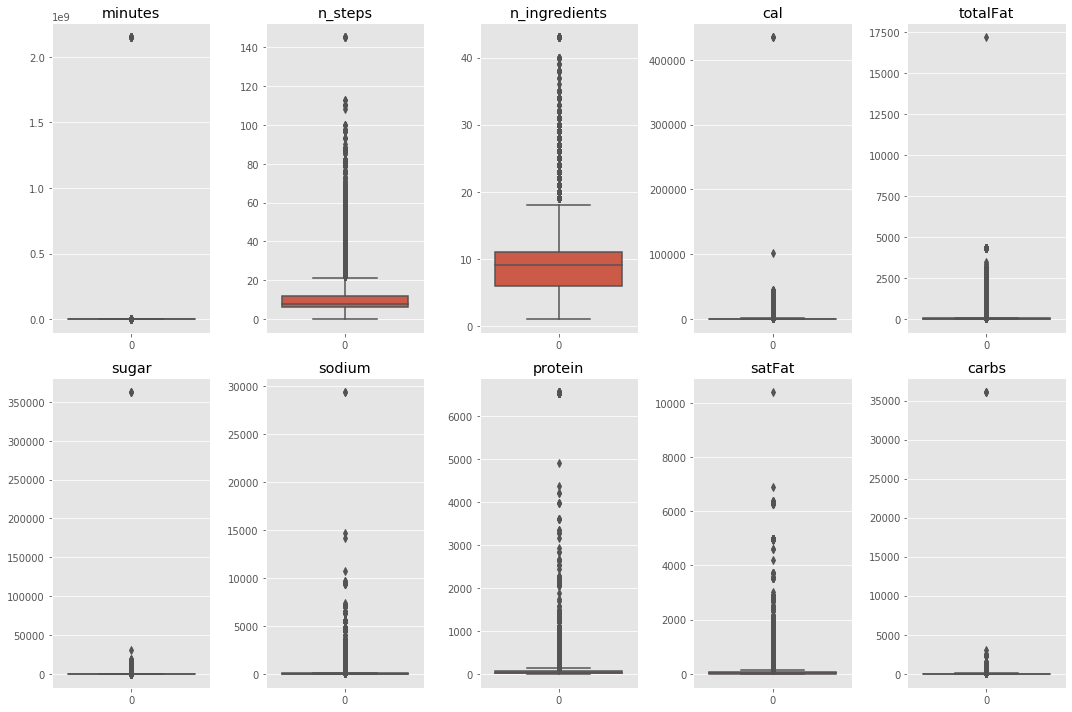

In [19]:
#Get all numeric columns
numeric_columns = ['minutes', 'n_steps', 'n_ingredients', 'cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs']

plt.style.use('ggplot')
fig, axis = plt.subplots(2,5,figsize=(15,10))
axis = axis.ravel()
for i,ax in enumerate(axis):
    sns.boxplot(data=Merged_Data2[numeric_columns[i]],ax=ax)
    ax.set(title=numeric_columns[i])
plt.tight_layout()
plt.show()

**There are many outliers, so we should remove outliers**

**To remove the outliers i will set my lower and upper bound as : lower bound = Q1 - 1.5 * IQR upper bound = Q3 + 1.5 * IQR.**


**The values out of these range are considered as outliers and we have to remove them.**


In [0]:
# Removing values according to IQR
Columns_Remove_Outliers=['n_steps','minutes','n_ingredients','cal', 'totalFat', 'sugar',   'sodium', 'protein', 'satFat', 'carbs']
for col in Columns_Remove_Outliers:
    IQR = Merged_Data2[col].quantile(0.75) - Merged_Data2[col].quantile(0.25)
    colmax = Merged_Data2[col].quantile(0.75) + 1.5 * IQR
    colmin = Merged_Data2[col].quantile(0.25) - 1.5 * IQR
    Merged_Data2 = Merged_Data2[ (Merged_Data2[col] < colmax) & (Merged_Data2[col] > colmin) ]


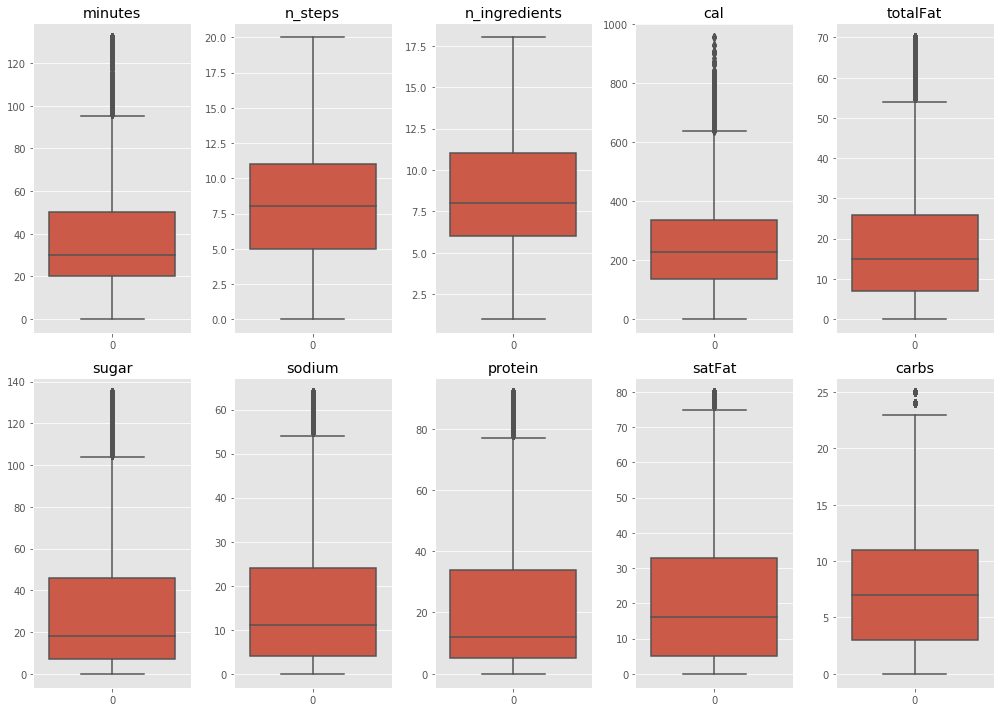

In [21]:
#Now we will look at distributions again
plt.style.use('ggplot')
fig, axis = plt.subplots(2,5,figsize=(14,10))
axis = axis.ravel()
for i,ax in enumerate(axis):
    sns.boxplot(data=Merged_Data2[numeric_columns[i]],ax=ax)
    ax.set(title=numeric_columns[i])
plt.tight_layout()
plt.show()

**This is much better than before removing the outliers**

**Removing Missing Values**

In [0]:
Merged_Data2.dropna(inplace= True)

**We can get many more insights from the data if we use the text in the reviews, Ingredients**



# Sentiment Classification

**Objective of the text analysis task we are trying to do:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).**


**But how to determine if a review is positive or negative?**

**We could use the Rating column. A rating of 4 or 5 can be cosnidered a positive review. A review of 1 or 2 can be considered as a negative review. A review of 3 is nuetral and ignored.** 

**This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.**

In [23]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
Merged_Data2['rating_positive_negative'] = Merged_Data2['rating'].apply(partition)
Merged_Data2['rating_positive_negative'].value_counts()



1    620549
0     47618
Name: rating_positive_negative, dtype: int64

**There is a serious class imbalance problem with our data**

**The issue of class imbalance can result in a serious bias towards the majority class, reducing the classification performance and increasing the number of false negatives**

**But, we should remember that this sampling doesn't introduce new information in the dataset, it (hopefully) merely shifts it around so as to increase the "numerical stability" of our resulting models.**

**We do under-sampling the majority class as this will result in an improved classification performance.**

**Before doing all these splitting we have to preprocess the data so that every split of data have undergone through same data manipulations**

# Text Preprocessing

In the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [0]:
#we are removing the words from the stop words list: 'no', 'nor', 'not'

STOP_WORDS= set([ 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


porter = PorterStemmer()
wnl = WordNetLemmatizer()
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub("\S*\d\S*", "", str(x)).strip()
    x = re.sub('[^A-Za-z0-9]+', ' ', str(x))
    #Stop word removal and Applying PorterStemmer
    #x = ' '.join(porter.stem(w) for w in x.split() if w not in STOP_WORDS)

    #Stop word removal and Applying WordNetLemmatizer
    x = ' '.join(wnl.lemmatize(w) for w in x.split() if w not in STOP_WORDS)
  
    return x


**Using the above function for review text pre processing**

In [0]:
Merged_Data2['Processed_Review'] = Merged_Data2['review'].apply(preprocess)

**Review Before Text Processing**

In [26]:
Merged_Data2['review'].values[2]

'Excellent recipe! I used butternut squash and the sweet option. The mexican spice mix put this over the top. Thanks for sharing.'

**Review after Text Processing**

In [27]:
Merged_Data2['Processed_Review'].values[2]

'excellent recipe used butternut squash sweet option mexican spice mix put top thanks sharing'

In [28]:
Merged_Data2.head(n=5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,cal,totalFat,sugar,sodium,protein,satFat,carbs,rating_positive_negative,Processed_Review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,used acorn squash sweet mexican spice blend us...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,nice change used butternut squash sweet option...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,excellent recipe used butternut squash sweet o...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"prepared pizza crust,sausage patty,eggs,milk,s...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ...",173.4,18.0,0.0,17.0,22.0,35.0,1.0,0,not tried sound delicious reminds layover atla...
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"prepared pizza crust,sausage patty,eggs,milk,s...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...,173.4,18.0,0.0,17.0,22.0,35.0,1.0,1,recipe wonderful instead using precooked sausa...


**Now the text is pre processed and ready for modeling!**


**We will first divide the dataset into Test Train sets and perform undersampling only on the training set.**

 **We will keep test set aside for our model performance measurement.**

In [29]:
Y = Merged_Data2['rating_positive_negative'].values
X = Merged_Data2['Processed_Review'].values
X_train, X_test, y_train, y_test = train_test_split(X.astype('U'), Y, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(447671,) (447671,)
(220496,) (220496,)


**Performing Under Sampling on majority class of train set**

In [30]:
from imblearn.under_sampling import RandomUnderSampler
UnderSampler = RandomUnderSampler(random_state=0)
X_resampled_Train, y_resampled_Train = UnderSampler.fit_resample(X_train.reshape(-1, 1), y_train)
print(X_resampled_Train.shape, y_resampled_Train.shape)
print("Value Counts",np.unique(y_resampled_Train, return_counts=True, axis=None))


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(63664, 1) (63664,)
Value Counts (array([0, 1]), array([31832, 31832]))


In [0]:
#Flattening the nd array
X_resampled_Train = X_resampled_Train.ravel()

**As we can see from above value counts of y_resampled, our train set is balanced.**

**Now we got a Balanced dataset to train our models on!**

# **Featurization**

**Now we will use different vectorization methods to convert the review text to vector representations**

# **Bag of Words**

In [0]:
def BOW(X_train, X_test):
  ''' Vectorize text using BOW count vectorizer'''
  vectorizer = CountVectorizer(max_features = 600 )
  # we use the fitted CountVectorizer to convert the text to vector
  X_train_bow = vectorizer.fit_transform(X_train)
  X_test_bow = vectorizer.transform(X_test)
  return X_train_bow.toarray(), X_test_bow.toarray()

In [0]:
X_train_bow, X_test_bow = BOW(X_resampled_Train, X_test = X_test ) 

# **Naive Bayes Classifer as baseline**

In [0]:
          
#Hyper paarmeter tuning for best alpha_GNB

def GaussianNaivebayes(X_train,y_train, X_test,y_test):

    ''' Function to train GNB on different alpha values and get train and test score accuracies'''

    # Create empty array to store results
    results = []
    # Enumerate through different max_depth values and store results
    for alpha in [1e-5, 1e-1,1]:
        GNB = GaussianNB(var_smoothing= alpha)
        GNB.fit(X_train,y_train)
        results.append(
            {
                'alpha': alpha,
                'train_AUC': metrics.roc_auc_score(y_train, GNB.predict_proba(X_train)[:, 1]),
                'test_AUC': metrics.roc_auc_score(y_test, GNB.predict_proba(X_test)[:, 1])
            })
    return results


In [0]:
Results = GaussianNaivebayes(X_train_bow,y_resampled_Train, X_test_bow, y_test)
Results

[{'alpha': 1e-05,
  'test_AUC': 0.7557575625331785,
  'train_AUC': 0.7595888284358651},
 {'alpha': 0.1,
  'test_AUC': 0.7938004426470079,
  'train_AUC': 0.7937538632038647},
 {'alpha': 1, 'test_AUC': 0.7793018250123488, 'train_AUC': 0.776987320057446}]

# **TF-IDF**

In [0]:
def TFIDF(preprocessed_reviews_Train, X_test):
      '''applying TF-IDF Vectorization on our corpus '''
      tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df= 3, max_features = 1000)
      tf_idf_vect.fit(preprocessed_reviews_Train)

      final_tf_idf_Train = tf_idf_vect.transform(preprocessed_reviews_Train)
      final_tf_idf_Test = tf_idf_vect.transform(X_test)
      return final_tf_idf_Train.toarray(), final_tf_idf_Test.toarray()
      print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
      print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

In [0]:
final_tf_idf_Train, final_tf_idf_Test = TFIDF(X_resampled_Train,X_test)

# **Naive Bayes Classifer as baseline**

In [0]:
Results = GaussianNaivebayes(final_tf_idf_Train,y_resampled_Train, final_tf_idf_Test, y_test)
Results

[{'alpha': 1e-05,
  'test_AUC': 0.7444937485805372,
  'train_AUC': 0.7490729209535784},
 {'alpha': 0.1,
  'test_AUC': 0.7708274949412369,
  'train_AUC': 0.7758290825519686},
 {'alpha': 1, 'test_AUC': 0.7856767526599981, 'train_AUC': 0.7887962734006615}]

# **Word2Vec Model using our own text corpus**

In [0]:

def Word2VecOnCorpus(sentences):
  ''' train my own Word2Vec model using our processed reviews text corpus '''
   #Preparing Reviews for gensim model 
  list_of_sentance_train=[]
  for sentance in sentences:
      list_of_sentance_train.append(sentance.split())

  # this line of code trains your w2v model on the give list of sentances
  w2v_model=Word2Vec(list_of_sentance_train,min_count=4,size=100, workers=4)

  w2v_words = list(w2v_model.wv.vocab)
  print("Number of words that occured minimum 4 times ",len(w2v_words))
  print("sample words ", w2v_words[0:50])
  print('='*50)
  print('Similar words to the given word using cosine similarity to investigate the learned representations')
  print(w2v_model.wv.most_similar('great'))
  print('='*50)
  print(w2v_model.wv.most_similar('bad'))

In [0]:
Word2VecOnCorpus(X_resampled_Train)

Number of words that occured minimum 4 times  9587
sample words  ['fantastic', 'not', 'use', 'shrimp', 'realized', 'quickly', 'time', 'consuming', 'year', 'old', 'daughter', 'help', 'wonderful', 'job', 'happy', 'enjoy', 'fruit', 'labor', 'first', 'making', 'transferring', 'fry', 'pan', 'another', 'stock', 'opposite', 'side', 'fried', 'big', 'mistake', 'steam', 'break', 'open', 'cant', 'wait', 'make', 'yummy', 'peeled', 'badly', 'method', 'tried', 'however', 'kit', 'promised', 'white', 'perfect', 'yolk', 'nice', 'creamy', 'yellow']
Similar words to the given word using cosine similarity to investigate the learned representations
[('wonderful', 0.8040202260017395), ('fantastic', 0.7554315328598022), ('excellent', 0.7246143817901611), ('terrific', 0.7150679230690002), ('awesome', 0.7146066427230835), ('good', 0.6847043037414551), ('perfect', 0.6596096754074097), ('fabulous', 0.6564327478408813), ('nice', 0.6284794211387634), ('amazing', 0.6016892194747925)]
[('funny', 0.765630841255188), 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# **Avg WordToVec**

**Building Word2Vec Model using our own text corpus and Computing average word2vec for each review by averaging vectors of all words in that review**

In [0]:
def AvgWord2VecRep(Train_Text, Test_Text):

    '''train my own Word2Vec model using our processed reviews text corpus and compute average word2vec for each review by averaging vectors of all words in that review'''
     #Preparing our train text for gensim model 
    list_of_sentance_train=[]
    for sentance in Train_Text:
      list_of_sentance_train.append(sentance.split())

    #Preparing our Test text for gensim model 
    list_of_sentance_Test=[]
    for sentance in Test_Text:
      list_of_sentance_Test.append(sentance.split())

    #Building Word2Vec Model using our own text corpus  
    w2v_model=Word2Vec(list_of_sentance_train,min_count=4,size=100, workers=4)
    w2v_words = list(w2v_model.wv.vocab)

    #Averaging word vectors of a sentence
    sent_vectors_Train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance_train): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 100
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors_Train.append(sent_vec)
    sent_vectors_Train = np.array(sent_vectors_Train)

    #Averaging word vectors of a sentence
    sent_vectors_Test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance_Test): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 100
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors_Test.append(sent_vec)
    sent_vectors_Test = np.array(sent_vectors_Test)

    return sent_vectors_Train, sent_vectors_Test
    

In [0]:
sent_vectors_Train, sent_vectors_Test = AvgWord2VecRep(X_resampled_Train, X_test)

100%|██████████| 220496/220496 [02:28<00:00, 1481.46it/s]


# **Naive Bayes Classifer as baseline**

In [0]:
Results = GaussianNaivebayes(sent_vectors_Train,y_resampled_Train, sent_vectors_Test, y_test)
Results

[{'alpha': 1e-05,
  'test_AUC': 0.7631061140869674,
  'train_AUC': 0.7647193860964847},
 {'alpha': 0.1,
  'test_AUC': 0.7676333141897924,
  'train_AUC': 0.7693219787235939},
 {'alpha': 1, 'test_AUC': 0.7641415961546183, 'train_AUC': 0.7661164387063407}]

# **TFIDF weighted Word2Vec**


In [0]:
def TfIdfWeightedW2V(preprocessed_text_Train, preprocessed_text_Test):

  '''Tf-Idf Weighted word2vec building by training on train data for each sentence/review in Train and Test data'''
  #TF-IDF Vectors
  model = TfidfVectorizer(ngram_range=(1,2), min_df=4, max_features = 10000)
  model.fit(preprocessed_text_Train)
  # we are converting a dictionary with word as a key, and the idf as a value
  dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
  tfidf_features = model.get_feature_names() # tfidf words/col-names

  #Preparing our train text for gensim model 
  list_of_sentance_train=[]
  for sentance in preprocessed_text_Train:
      list_of_sentance_train.append(sentance.split())

  #Preparing our test text for gensim model 
  list_of_sentance_test=[]
  for sentance in preprocessed_text_Test:
      list_of_sentance_test.append(sentance.split())

  #Building Word2Vec Model using our own text corpus(Train set)
  w2v_model=Word2Vec(list_of_sentance_train,min_count=2,size=50, workers=4)
  w2v_words = list(w2v_model.wv.vocab)

  tfidf_W2V_sent_vectors_Train = []; # the tfidf-w2v for each sentence/review of train data is stored in this list
  tfidf_W2V_sent_vectors_Test = []; # the tfidf-w2v for each sentence/review of test data is stored in this list

  for sent in tqdm(list_of_sentance_train): # for each review/sentence 
      sent_vec = np.zeros(50) # as word vectors are of Length 50
      weight_sum =0; # num of words with a valid vector in the sentence/review
      for word in sent: # for each word in a review/sentence
          if word in w2v_words and word in tfidf_features:
              vec = w2v_model.wv[word]

              #dictionary[word] is idf value of word in whole courpus
              #sent.count(word) is tf valeus of word in this review/sentence
              tf_idf = dictionary[word]*(sent.count(word)/len(sent))
              sent_vec += (vec * tf_idf)
              weight_sum += tf_idf
      if weight_sum != 0:
          sent_vec /= weight_sum
      tfidf_W2V_sent_vectors_Train.append(sent_vec)

  for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of Length 50
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_features:
            vec = w2v_model.wv[word]

            #dictionary[word] is idf value of word in whole courpus
            #sent.count(word) is tf valeus of word in this review/sentence
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_W2V_sent_vectors_Test.append(sent_vec)
      
  return tfidf_W2V_sent_vectors_Train, tfidf_W2V_sent_vectors_Test
      

In [0]:
tfidf_W2V_sent_vectors_Train, tfidf_W2V_sent_vectors_Test = TfIdfWeightedW2V(X_resampled_Train,X_test)

100%|██████████| 220496/220496 [17:43<00:00, 207.25it/s]


In [0]:
tfidf_W2V_sent_vectors_Test[0]

array([-0.56219826, -0.05624155, -1.18498702,  1.83769257,  1.99390624,
       -1.25672717, -1.75069606, -0.66475733, -0.45281235, -0.53679233,
       -1.12492571, -0.2610538 , -1.54051755, -1.30112732, -0.33372819,
        0.56872972,  2.47081045,  0.78553347, -0.97922675,  1.34127511,
       -1.27404991,  0.40354619, -1.76854297,  0.08374895, -0.74740257,
        1.12253628,  0.95739536, -1.43082001,  1.93709868, -1.66396579,
       -1.69279691,  1.74920847,  1.36378285, -1.22247401, -1.34130138,
       -0.00788731,  0.33560264,  1.19862311, -0.50578233,  0.30333724,
        1.35283639, -1.25623538,  1.14405872,  0.73286868, -1.58333078,
        0.48113079,  0.31907965, -0.34799584, -1.010129  ,  0.40710165])

# **Naive Bayes Classifer as baseline**

In [0]:
Results = GaussianNaivebayes(tfidf_W2V_sent_vectors_Train,y_resampled_Train, tfidf_W2V_sent_vectors_Test, y_test)
Results

[{'alpha': 1e-05,
  'test_AUC': 0.7347776230422126,
  'train_AUC': 0.7283369469128659},
 {'alpha': 0.01,
  'test_AUC': 0.7354769324424782,
  'train_AUC': 0.7290016076637275},
 {'alpha': 0.1,
  'test_AUC': 0.740200173738681,
  'train_AUC': 0.7335146144573674},
 {'alpha': 1, 'test_AUC': 0.7452514070423262, 'train_AUC': 0.7385340409072733}]

# **Predictive Modelling**



*   **After looking at baseline result of naive bayes for each type of vectorization. We see TF-IDF performed better. SO we will use TF-IDF vector representations of text and build more complex models to see if we get better AUC score**



*  **In This section I've implemented XGBoost and Neural Network algorithms and tuned their Hyper-parameters to increase the AUC. The models are:**



1.   **XGBoost Gradient Boosting Classifier**
2.   **Aritificial Neural Networks**



# **Building Deep Neural Neural network classification model using Keras with Tensorflow as Backend**

In [0]:
from keras.utils import to_categorical
Predictors = final_tf_idf_Train 
target = to_categorical(y_resampled_Train)

In [0]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD

# Import EarlyStopping
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)
n_cols = Predictors.shape[1]
model = Sequential()
model.add(Dense(100,activation='relu',input_shape = (n_cols,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
#model.add(Dense(200,activation='relu'))
#model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model

model.fit(Predictors, target, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=True)
predictions = model.predict(final_tf_idf_Test)

#Train/Test AUC scores

train_auc = metrics.roc_auc_score(y_resampled_Train,model.predict_proba(final_tf_idf_Train)[:, 1])
test_auc = metrics.roc_auc_score(y_test,model.predict_proba(final_tf_idf_Test)[:, 1])

print("train_auc=",train_auc)
print("test_auc=",test_auc)





Train on 51094 samples, validate on 12774 samples
Epoch 1/15
51094/51094 [==============================] - 96s 2ms/step - loss: 0.5065 - acc: 0.7386 - val_loss: 0.7233 - val_acc: 0.6543
Epoch 2/15
51094/51094 [==============================] - 88s 2ms/step - loss: 0.4615 - acc: 0.7702 - val_loss: 0.7415 - val_acc: 0.6404
Epoch 3/15
51094/51094 [==============================] - 87s 2ms/step - loss: 0.4073 - acc: 0.8094 - val_loss: 0.8498 - val_acc: 0.5666
Epoch 4/15
51094/51094 [==============================] - 85s 2ms/step - loss: 0.3147 - acc: 0.8626 - val_loss: 0.9809 - val_acc: 0.5645
train_auc= 0.9445060128222356
test_auc= 0.8064264131133467


# **XGBoost Classification Model**

**XGBoost Model Tuning**



*   Performing Random Search to find best Hyperparameters


In [0]:
gamma = [0,1,5]
# max depth of the tree
max_depth = [3,5,10,15,20]
# no of variables that are being used in tree
colsample_bytree = [0.3,0.5,0.8]
# Minimum number of samples required at each leaf node
subsample = [0.8,0.9,1]
# learning rate for gradient descent
learning_rate = [0.01,0.03,0.05,0.1]
# Create the random grid
random_grid = {'gamma': gamma,
               'max_depth': max_depth,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample,
               'learning_rate': learning_rate}
XGBoost = XGBClassifier()
rf_random = RandomizedSearchCV(estimator = XGBoost, param_distributions = random_grid, n_iter = 10, cv = 2,random_state=42, n_jobs = -1)
rf_random.fit(final_tf_idf_Train,y_resampled_Train)
rf_random.best_estimator_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5,
              learning_rate=0.05, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

Fitting the above Hyperparameter tuned model with training data

In [0]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5,
              learning_rate=0.05, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
model.fit(final_tf_idf_Train,y_resampled_Train)
Train_AUC  =  metrics.roc_auc_score(y_resampled_Train, model.predict_proba(final_tf_idf_Train)[:, 1])
Test_AUC  =  metrics.roc_auc_score(y_test, model.predict_proba(final_tf_idf_Test)[:, 1])
print("train_auc=",Train_AUC)
print("test_auc=",Test_AUC)

train_auc= 0.9038271050986983
test_auc= 0.8307068128970503


**XGBClassifier gave the best Test_AUC score. So we will use that for predictions on new data.**

**Word cloud of reviews to see the most used words in recipe reviews**

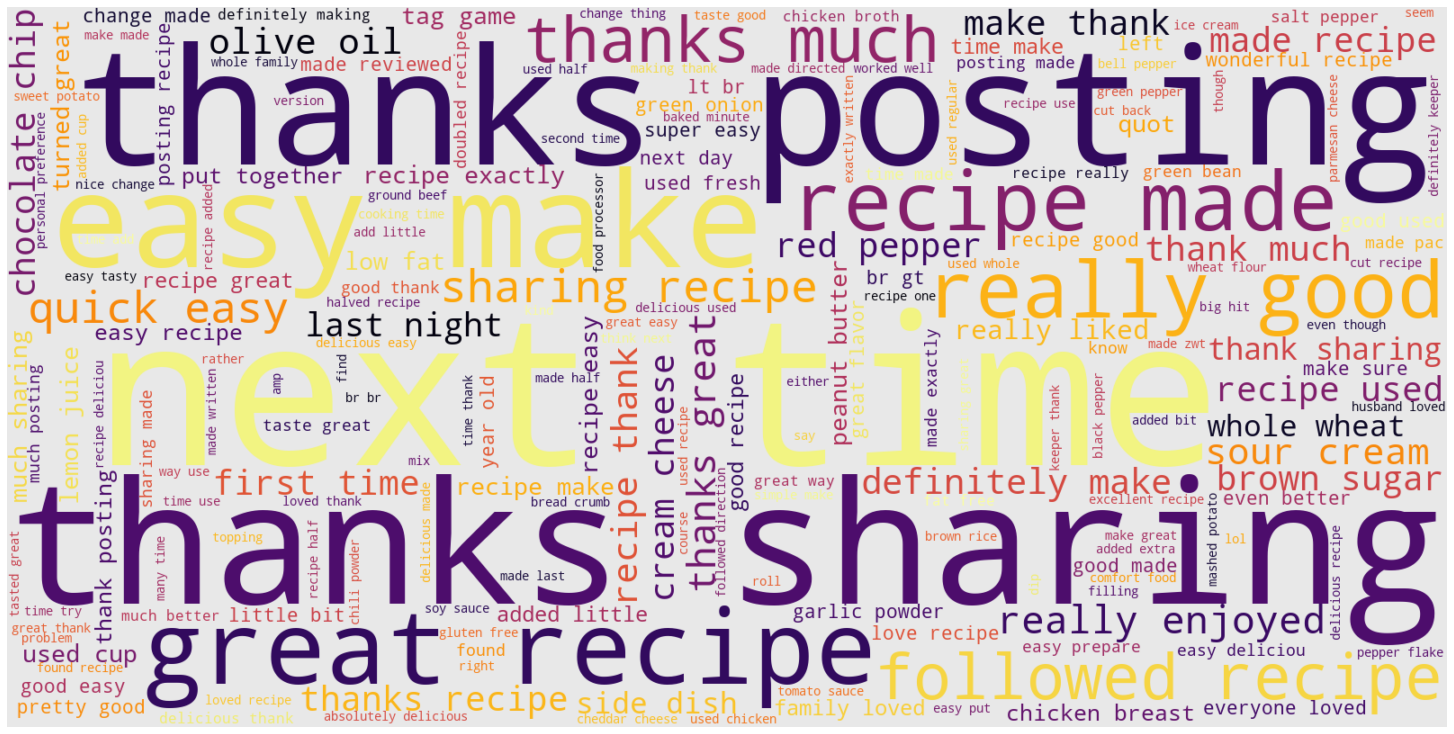

In [32]:
%matplotlib inline
from wordcloud import WordCloud

Text=Merged_Data2.Processed_Review.str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, background_color="#E8E8E8",colormap="inferno_r", min_font_size = 10).generate(Text) 
%matplotlib inline
# plot the WordCloud image                        
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear') 

plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 
  


#**Feature Engineering Cuisine**

**Surprisingly there is no Cuisine information in the data.**

**It would be very helpful if we know which cuisine a recipe belongs to. So that we can further analyze things like which cuisine have more positive reviews, which cuisine have high nutritional value etc.**


**I've searched the datasets which contain cusine information and found a dataset that has ingredients and cuisine information.**

**We can use that data to train a model and use that model to predict cuisines for our dataset.**

**Let's start by importing it.**

In [32]:
train_Cuisines = pd.read_json('/content/drive/My Drive/Colab Notebooks/Food_Data/train.json')
train_Cuisines.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."




*   **As we are dealing with textual data we have to vectorize ingreidents text.**
*  **For this we will use TF-IDF Vectorizer instad of count vectorizer as it will take into consideration the Frequency of words in document(TF) and also the frequency in all corpus documents(IDF)**

In [33]:
train_Cuisines['ingredient_list'] = [','.join(z).strip() for z in train_Cuisines['ingredients']]

ingredients = train_Cuisines['ingredient_list']

Tfidfvectorizer = TfidfVectorizer(ngram_range=(1,2), min_df= 3, max_features = 1000, stop_words='english')

tfidf_dense_matrix= Tfidfvectorizer.fit_transform(ingredients).todense()
cuisines = train_Cuisines['cuisine']

print("TF-IDF Matrix looks like below :\n",tfidf_dense_matrix,"\n")
print("Cuisine looks like below :\n",cuisines.head(),"\n")

TF-IDF Matrix looks like below :
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Cuisine looks like below :
 0          greek
1    southern_us
2       filipino
3         indian
4         indian
Name: cuisine, dtype: object 



In [0]:
tfidf_dense_matrix.shape

* **XGBoost model has the best accuracy scores after trying several models in our research**

* **We will use XGBoost model to train a model to predict cuisines given ingredients**

* **First we will split dataset into train and test sets.**

* **We will use train set for hyper parameter tuning using random search**


* **We will use test set to see how well our trained model performs on unseen data** 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_dense_matrix, cuisines, test_size=0.3)


**We will fine tune XGBoost now.**

In [0]:
gamma = [1,5]
# max depth of the tree
max_depth = [15,20,25]
# no of variables that are being used in tree
colsample_bytree = [0.5,0.8]
# Minimum number of sam`ples required at each leaf node
subsample = [0.9,1]
# learning rate for gradient descent
learning_rate = [0.09,0.1]
# Create the random grid
random_grid = {'gamma': gamma,
               'max_depth': max_depth,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample,
               'learning_rate': learning_rate}
XGBoost = XGBClassifier()
rf_random = RandomizedSearchCV(estimator = XGBoost, param_distributions = random_grid, n_iter = 10, cv = 2,random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_estimator_



**So, we will use hyperparameter tuned XGBoost model  to finally train on all the train data and test it on test set to see it's per class recall and precision**

In [0]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1,
              learning_rate=0.09, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)
model.fit(X_train,y_train)
Test_pred = model.predict(X_test)



# **How accurate is the model ?**

We will measure,

*   The Accuracy of the model 
*   Classification rate (Using classification report for each class in target)



In [37]:
print("mtest set accuracy : ",accuracy_score(y_test, Test_pred))
cuisines = train_Cuisines['cuisine'].value_counts().index
print(classification_report(y_test, Test_pred, target_names=cuisines))

mtest set accuracy :  0.7448252744490069
              precision    recall  f1-score   support

     italian       0.67      0.43      0.52       141
     mexican       0.56      0.26      0.35       238
 southern_us       0.81      0.72      0.76       484
      indian       0.75      0.84      0.79       812
     chinese       0.74      0.49      0.59       219
      french       0.52      0.54      0.53       771
cajun_creole       0.78      0.58      0.67       361
        thai       0.84      0.90      0.87       885
    japanese       0.66      0.33      0.44       196
       greek       0.74      0.87      0.80      2374
     spanish       0.83      0.62      0.71       154
      korean       0.81      0.63      0.71       456
  vietnamese       0.78      0.65      0.71       262
    moroccan       0.86      0.92      0.89      1885
     british       0.81      0.59      0.69       251
    filipino       0.72      0.30      0.42       142
       irish       0.62      0.78      0

**Now our model is ready to be deployed and we can start predicting the cuisine given the ingridents.** 

*  **We just have to make sure that since we trained our model with the TF_IDF vectorizer we must use the same for Tranforming original Ingredients data.**

*  **We will now predict cuisines for the original data set using the same model we trained on previously(XGBoost) .**

In [38]:

#Vectorize ingredients based on previously fitted Tfidfvectorizer
ingredients_matrix = Tfidfvectorizer.transform(Merged_Data2['ingredients'])


#Use previously created randomforest model trained on kaggle cuisine data
cuisines_for_ingredients = model.predict(ingredients_matrix)


#Create new cuisine column in original dataframe
Merged_Data2['cuisine'] = cuisines_for_ingredients
Merged_Data2.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,cal,totalFat,sugar,sodium,protein,satFat,carbs,rating_positive_negative,Processed_Review,cuisine
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,used acorn squash sweet mexican spice blend us...,mexican
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,nice change used butternut squash sweet option...,mexican
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"winter squash,mexican seasoning,mixed spice,ho...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,1,excellent recipe used butternut squash sweet o...,mexican
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"prepared pizza crust,sausage patty,eggs,milk,s...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ...",173.4,18.0,0.0,17.0,22.0,35.0,1.0,0,not tried sound delicious reminds layover atla...,italian
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"prepared pizza crust,sausage patty,eggs,milk,s...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...,173.4,18.0,0.0,17.0,22.0,35.0,1.0,1,recipe wonderful instead using precooked sausa...,italian


**We added cuisine information for each recipe!!**

# Now we will look into various visuals that answer many questions regarding cusines.

**Which cusine have average highest Ratings?**

In [39]:
DataFrameVis = Merged_Data2.groupby('cuisine')['rating'].agg(['mean','count'])\
                                                        .rename(columns={"mean": "average_rating", "count": "No_of_Reviews"})
DataFrameVis.reset_index(inplace=True)    
DataFrameVis.sort_values(by=['average_rating','No_of_Reviews'], ascending= False)                                                 

,cuisine,average_rating,No_of_Reviews
6,greek,4.550518,14470
17,spanish,4.531382,3792
19,vietnamese,4.483539,972
5,french,4.477897,41398
12,korean,4.466747,3338
9,italian,4.466676,178518
2,cajun_creole,4.464728,7598
14,moroccan,4.463595,4862
13,mexican,4.450259,76989
18,thai,4.439710,5938


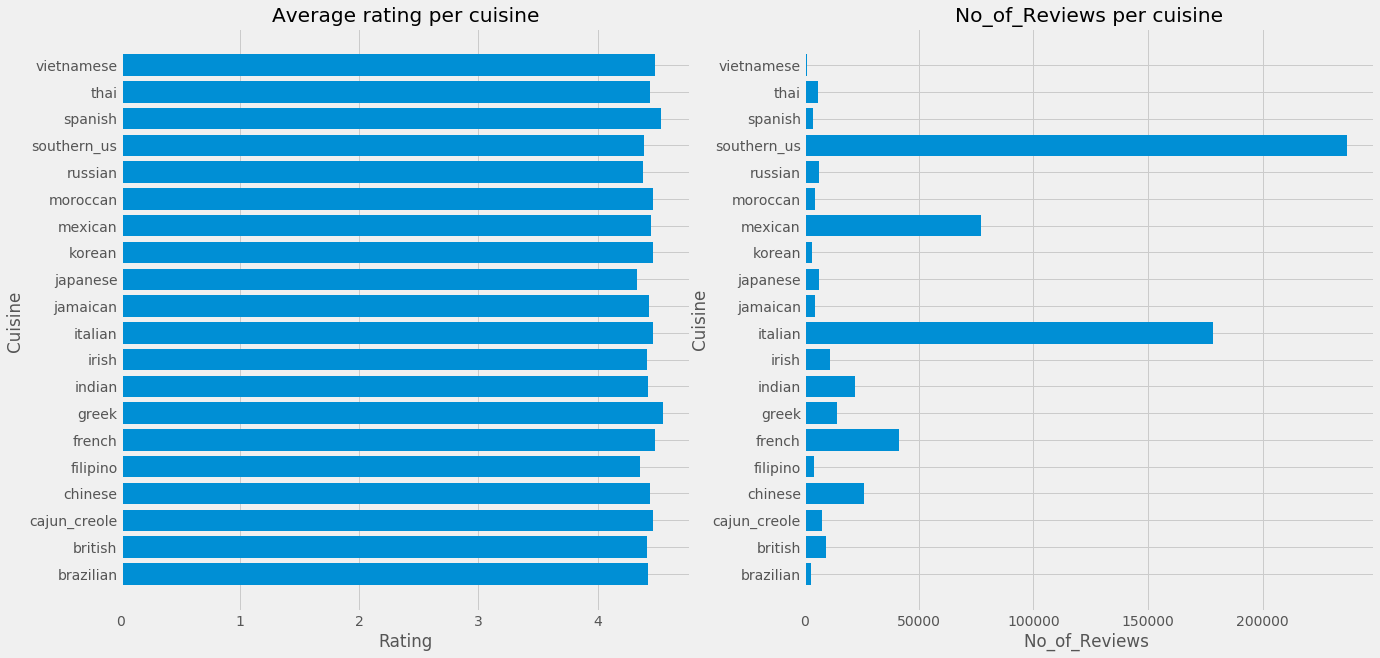

In [41]:
fig , (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
plt.style.use('fivethirtyeight')
ax1.barh(y= DataFrameVis['cuisine'], width= DataFrameVis['average_rating'])
ax1.set(xlabel='Rating', ylabel='Cuisine ',title="Average rating per cuisine")


ax2.barh( y= DataFrameVis['cuisine'], width=DataFrameVis['No_of_Reviews'])
ax2.set(ylabel='Cuisine', xlabel='No_of_Reviews ',title="No_of_Reviews per cuisine")

plt.show()


* **Now we will visualize count of recipes we have for each cuisine in food.com and** 
* **Avgerage Number of minutes per cuisine**

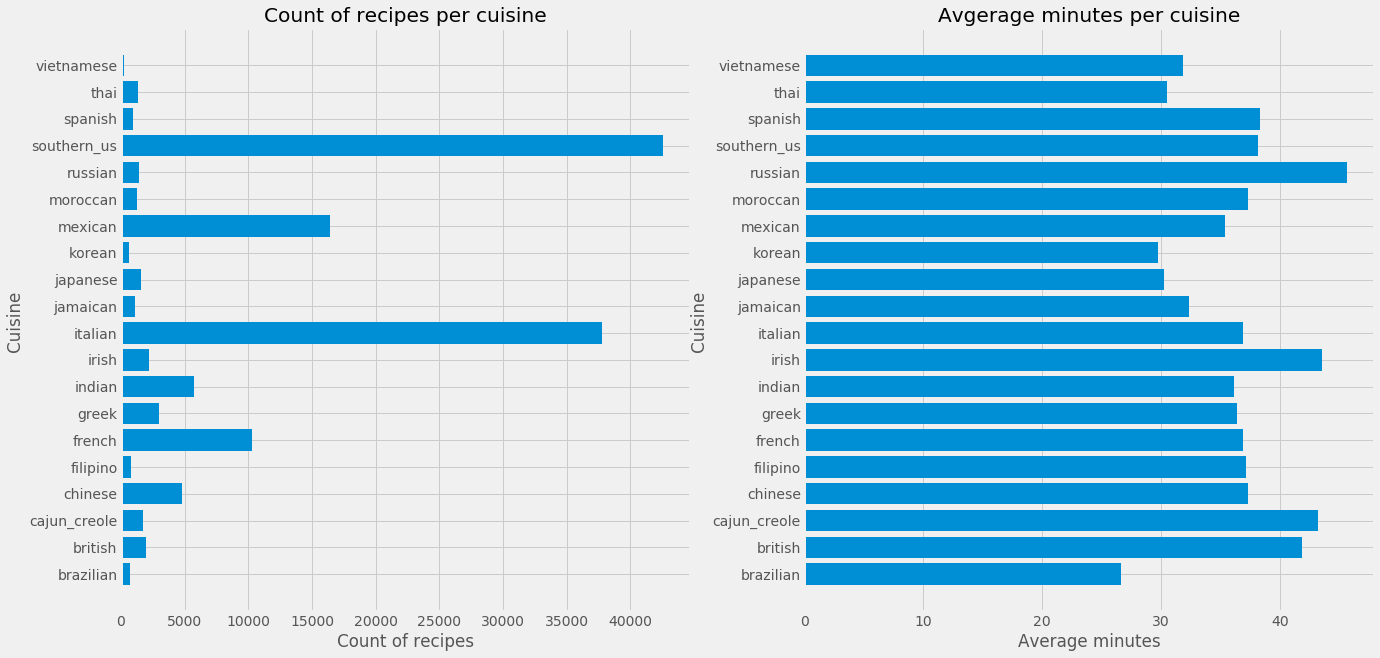

In [45]:
DataFrameVis = Merged_Data2.groupby('cuisine')['recipe_id'].nunique()
DataFrameVis = pd.DataFrame(DataFrameVis)
DataFrameVis.reset_index(inplace=True)

DataFrameVis1 = Merged_Data2.groupby('cuisine')['minutes'].agg('mean')
DataFrameVis1 = pd.DataFrame(DataFrameVis1)
DataFrameVis1.reset_index(inplace=True)

fig ,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
plt.style.use('fivethirtyeight')
ax1.barh(y= DataFrameVis['cuisine'], width= DataFrameVis['recipe_id'])
ax1.set(xlabel='Count of recipes', ylabel='Cuisine ',title="Count of recipes per cuisine")

#fig ,ax1 = plt.subplots(1,1,figsize=(10,10))
#plt.style.use('fivethirtyeight')
ax2.barh(y= DataFrameVis1['cuisine'], width= DataFrameVis1['minutes'])
ax2.set(xlabel='Average minutes', ylabel='Cuisine ',title="Avgerage minutes per cuisine")
#plt.xticks(rotation=65)
plt.show()

# Clustering 
* **By looking at the above visualization we can clearly observe the domination of some cusines over other cusines and surprisingly we see similar ratings for each cusine. There's not much of a trend**

* **The number of ratings per cuisine doesn't specifically give us any information given the high volumes of recipes for specific cuisines.**

* **We can further dive deep into this and research if we can find some interesting answers to questions like what king of recipes group together and what kind of recipes become more popular based on some other values available in the data.**

* **We can use clustering for this kind of un-supervised learning task.**

# Clustering to Dig deep into recipe ratings

In [39]:
#Clustering by ingredients

#We will cluster data points using the ingredients data and see if we can find interesting patterns in those clusters

#Creating Vectorizer model, with taking top 1000 words from the ingredients text
vectorize = TfidfVectorizer(max_features= 1000, stop_words='english')

ingredients_matrix = vectorize.fit_transform(Merged_Data2['ingredients'])

#Converting the spared matrix to dense matrix and creating pandas DF from it
ingredients_DF = pd.DataFrame(ingredients_matrix.todense(),index=Merged_Data2.index)
ingredients_DF.columns=vectorize.get_feature_names()
ingredients_DF.head(10)



,10,accent,acorn,active,added,adobo,agave,albacore,ale,alfredo,allspice,almond,almonds,aluminum,amaretto,amarula,american,ancho,anchovy,andouille,angel,anise,apple,apples,applesauce,apricot,apricots,arborio,artichoke,artichokes,artificial,arugula,asiago,asparagus,avocado,avocados,baby,bacon,bag,bagels,...,walnut,walnuts,warm,wasabi,water,watercress,watermelon,wax,wedge,wedges,weed,wheat,whip,whipped,whipping,whiskey,white,whites,wide,wild,wine,wings,wonton,wooden,worcestershire,wrap,wrappers,wraps,xanthan,yams,yeast,yellow,yoghurt,yogurt,yolk,yolks,yukon,zest,ziti,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.133058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Using truncated SVD ON sparce matrix to reduce the dimentionality of data

from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components = 60)
ingredients_DF = model.fit_transform(ingredients_DF)


Now we should find optimal no of clusters(k) for k-means clustering

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


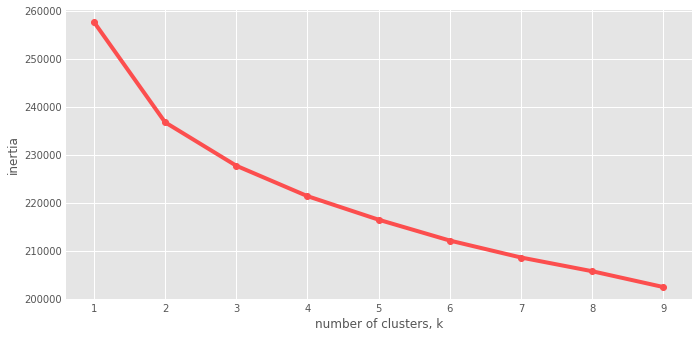

In [0]:


#Passing the vectorized matrix created above to k-Means model for clustering
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=0, n_jobs = -1)
    
    # Fit model to samples
    model.fit(ingredients_DF)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
#elbow plot to find the optimal K
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.plot(ks, inertias, '-o', color='#FC4E4E')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


From the above elbow plot, we cannot discern a K value easily. Even though the graph is not straightforward, we have reasonable doubt between values 4,5 & 6.

In this case, we will need another method to find the optimal K from the values 4,5 & 6.

We will use the silhouette score.

Silhouette method measures how similar a point is to it’s own cluster compared to others.
It is more likely a validation rather than a decision maker. Which is exactly what we want in this scenario.

By using Euclidean distance as the metric, we will plot the graph for silhouette scores for the three values of K.

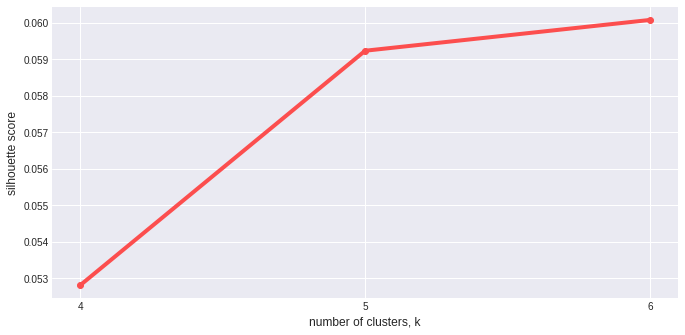

In [0]:

#Passing the vectorized matrix created above to k-Means model for clustering
kvalue = range(4, 7)
sil = []

for k in kvalue:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=0)
    
    # Fit model to samples
    model.fit(ingredients_DF)
    labels = model.labels_
    sil.append(silhouette_score(ingredients_DF, labels, metric = 'euclidean'))

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,5))
plt.plot(kvalue, sil, '-o', color='#FC4E4E')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(kvalue)
plt.show()


From the above graph, we can say that the 6 is the most optimal value for K.

In [55]:
model = KMeans(n_clusters=6, random_state=0)
model.fit(ingredients_DF)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

The number of recipes in each cluster

In [56]:
Merged_Data2['ingredients_Cluster'] = model.labels_
Merged_Data2['ingredients_Cluster'].value_counts()

3    181993
5    158752
1    108119
2     97177
0     61368
4     60758
Name: ingredients_Cluster, dtype: int64

Now we will look at top-ingredients in each of our clusters.

In [57]:
print('\nCrucial ingredients for each clusters: \n')
features = vectorize.get_feature_names()
centroids = model.cluster_centers_.argsort()[:,::-1]
for clust in range(0,6):
    print('Cluster '+str(clust)+': ')
    for ind in centroids[clust, :15]:
        print(features[ind]+' ', end='')
    print()
    print()


Crucial ingredients for each clusters: 

Cluster 0: 
10 adobo ale acorn active amarula alfredo albacore aluminum amaretto angel anchovy bamboo baby bag 

Cluster 1: 
10 acorn agave andouille added arugula apple amaretto apricots aluminum allspice avocados ancho artificial bacon 

Cluster 2: 
10 accent added agave adobo aluminum ale arborio allspice anise angel apples bacon basil amaretto 

Cluster 3: 
10 accent almond albacore alfredo artichokes andouille artichoke apricot applesauce amaretto amarula ancho baileys artificial 

Cluster 4: 
10 active allspice american almonds alfredo asparagus agave apple apricot asiago artichokes avocado base beaters 

Cluster 5: 
10 added ale almond albacore anchovy apples artichoke apricot arugula artichokes bananas basil bean amaretto 



Summarizing the data on Cluster number to look at some properties

In [70]:
results = Merged_Data2.groupby(['ingredients_Cluster'])['minutes','nutrition', 'n_steps','n_ingredients','rating', 'cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs'].mean().sort_values('rating')
results

,minutes,n_steps,n_ingredients,rating,cal,totalFat,sugar,sodium,protein,satFat,carbs
ingredients_Cluster,,,,,,,,,,,
2,40.239007,9.950801,9.666289,4.316227,212.838436,13.487739,54.537854,9.654147,7.405158,18.763246,9.475256
3,31.003275,7.657349,6.282395,4.421978,202.251486,13.217778,44.392510,8.709357,11.406658,17.485667,7.586523
4,39.004789,8.220004,9.775667,4.430330,269.382601,19.424734,28.627934,27.560157,34.809112,18.601353,6.328105
0,44.965014,9.172924,9.129791,4.445933,319.123035,21.973211,17.612893,23.518316,45.567755,25.626890,7.189838
1,40.078432,8.724276,8.233622,4.464562,296.655471,24.181772,13.551642,22.612954,29.701107,36.337351,7.320637
5,37.006350,8.337665,9.534885,4.489814,244.685509,18.351170,18.059319,15.732035,22.575420,16.941683,7.232973


**If we observe our cluster statistics. We can see two important patters.**



1.   **Cluster that has the highes average rating has the lowest sugar values and the highest protein values**
2.   **cluster with the least average rating has the highest sugar values and the least protein values**

**So we can say that people on Food.com are gives highest rating to health choices that have low suger and high protein content in particular.**


**Now we will plot bar-plots showing the sugar and protein levels of each cluster.**

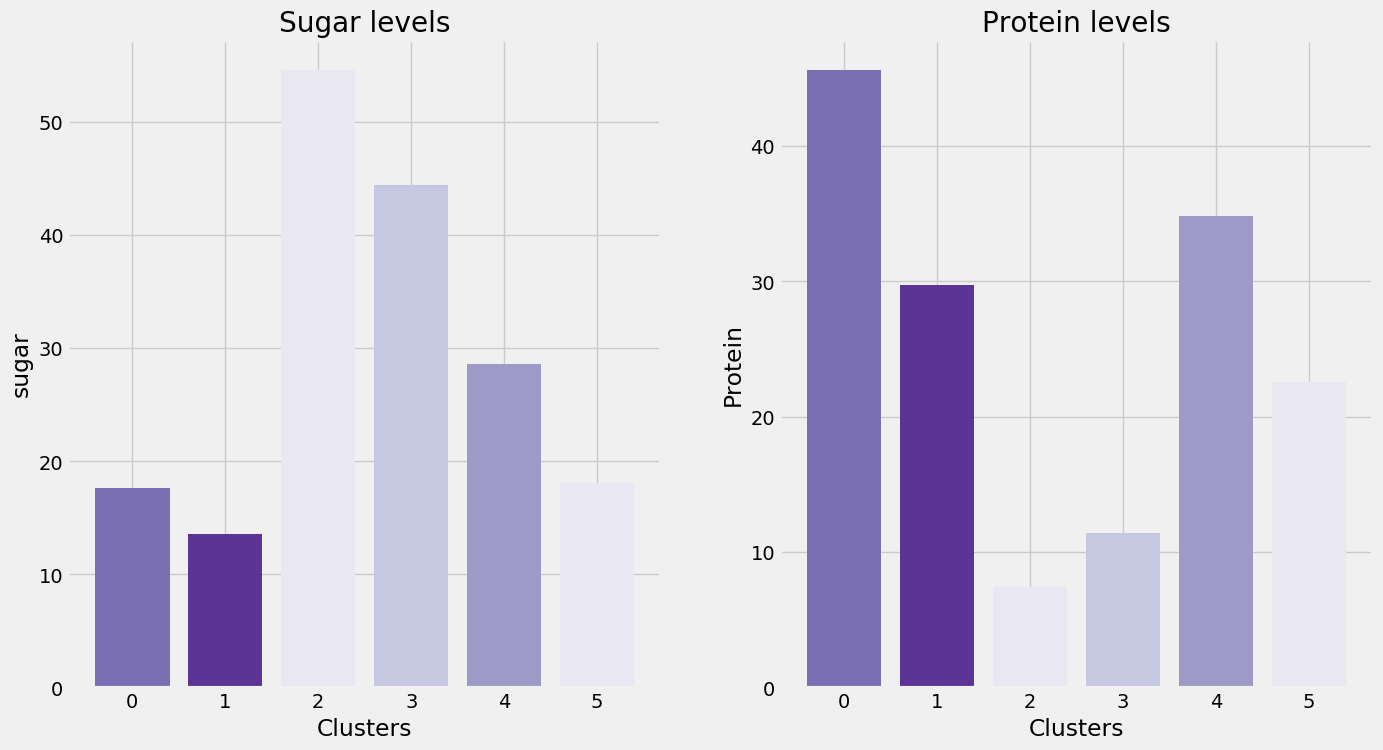

In [75]:
import matplotlib.cm as cm
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].bar(results.index,results.sugar, color=sns.color_palette("Purples",5))
ax[0].set(title="Sugar levels",xlabel="Clusters",ylabel="sugar")
ax[1].bar(results.index,results.protein, color=sns.color_palette("Purples",5))
ax[1].set(title="Protein levels",xlabel="Clusters",ylabel="Protein")
plt.show()

**Darker the purple color, higher the rating of the cluster. So We can see clearly from above plots that recipes with higher sugar content and lower protein has least rating compared to recipes with High protein and low sugar levels**

# **We will make word clouds for ingredients in most popular and least popular clusters**

**Word cloud of ingredients for Cluster with highest ratings**

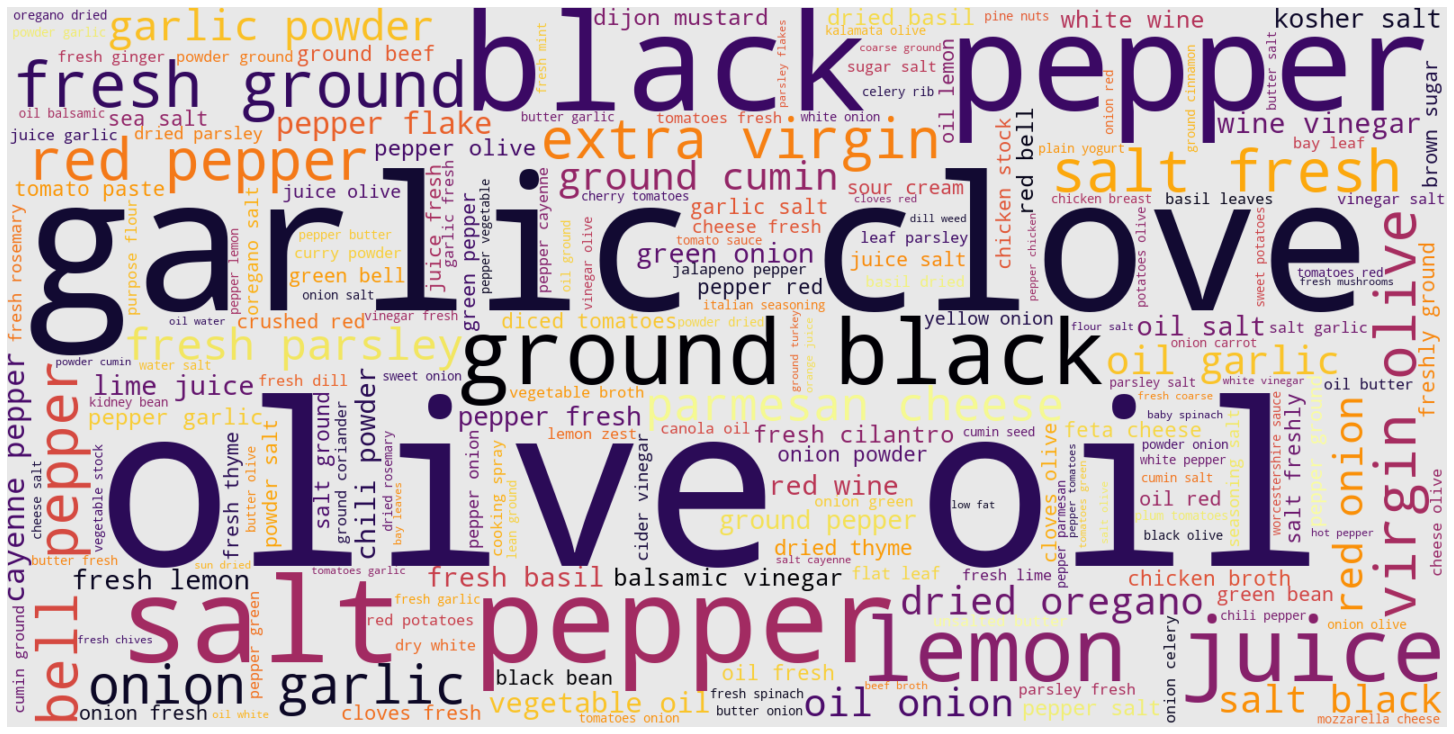

In [82]:

text = Merged_Data2[Merged_Data2.ingredients_Cluster == 5].ingredients.str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, background_color="#E8E8E8",colormap="inferno_r", min_font_size = 10).generate(text) 
%matplotlib inline
# plot the WordCloud image                        
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear') 

plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 


**Word cloud of ingredients for Cluster with highest ratings**

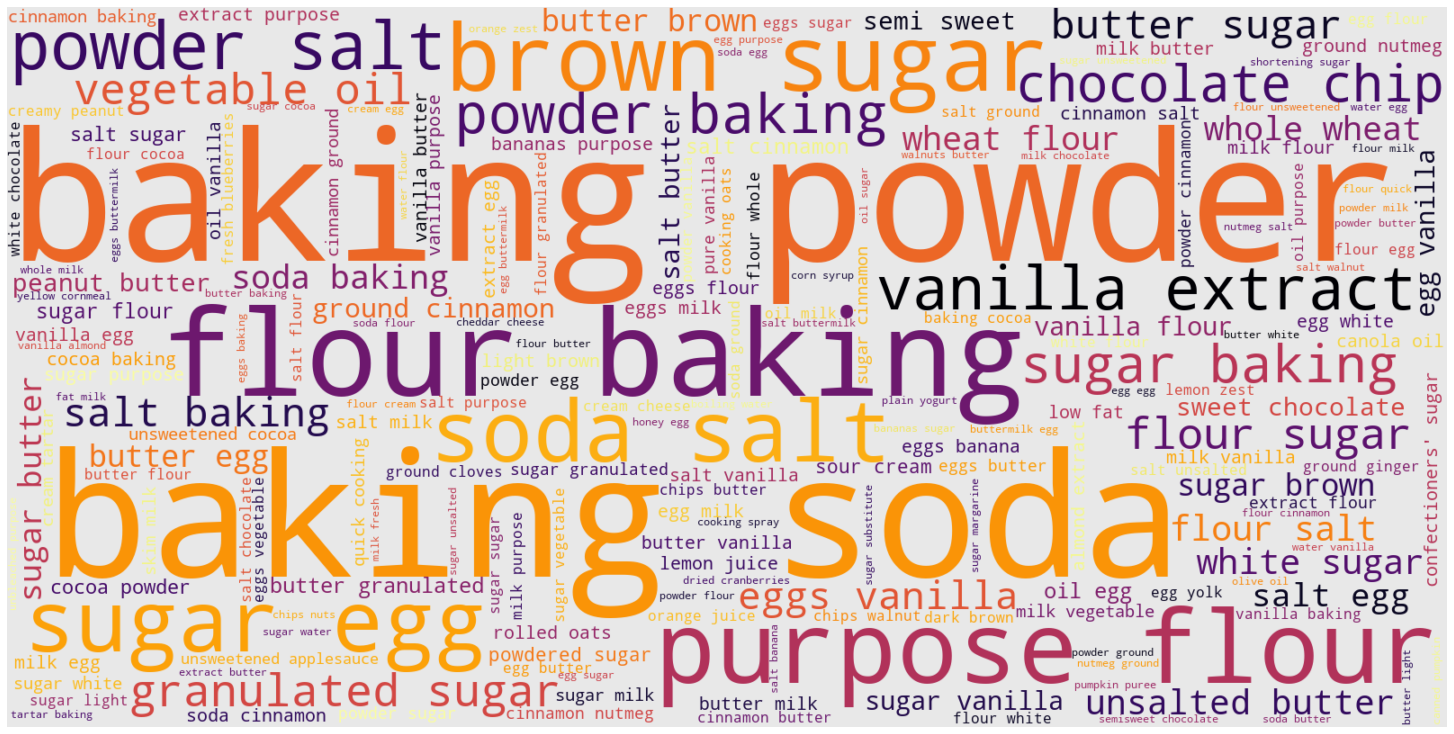

In [83]:
text = Merged_Data2[Merged_Data2.ingredients_Cluster == 2].ingredients.str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, background_color="#E8E8E8",colormap="inferno_r", min_font_size = 10).generate(text) 
%matplotlib inline
# plot the WordCloud image                        
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear') 

plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# **Market Baset Analysis on Ingredients using Apriori**

**If This Food.com wants to sell ingredients then when is the  best we we can increase the sales of the ingredients?**

* **We should find a way to recommend additional products to customers based on what they have in cart.**

* **The best way to do this is by using market basket analysis by implementing Apriori algorithm.**

* **As we already have the common ingredients for a recipe as a list. We can use those lists to give input to apriori algorithm for it to learn the associations.**

In [0]:

Merged_Data2['ingredient_list'] = [z.split(",") for z in Merged_Data2['ingredients']]

In [0]:
Merged_Data2['ingredient_list'][1:888]


1       [winter squash, mexican seasoning, mixed spice...
2       [winter squash, mexican seasoning, mixed spice...
3       [prepared pizza crust, sausage patty, eggs, mi...
4       [prepared pizza crust, sausage patty, eggs, mi...
5       [prepared pizza crust, sausage patty, eggs, mi...
                              ...                        
1783         [ouzo, orange juice, ice cube, orange slice]
1784         [ouzo, orange juice, ice cube, orange slice]
1785         [ouzo, orange juice, ice cube, orange slice]
1786         [ouzo, orange juice, ice cube, orange slice]
1787         [ouzo, orange juice, ice cube, orange slice]
Name: ingredient_list, Length: 887, dtype: object

I tried many parameter values of Support, Confidence and Lift for apriori model.I've selected min_support to be 0.0060, min_confidence=0.6, min_lift=3 as desired values for our Apriori algorithm.

Running Apriori algorithm on the Ingredients list of lists 

In [0]:

associationRules = apriori(Merged_Data2['ingredient_list'], min_support=0.0040, min_confidence=0.4, min_lift=3, min_length=5,max_length=None)
associationResult = list(associationRules)

print("\n\nNumber of Rules:")
print(len(associationResult))

print("\n\nExample of a rule:")
print(associationResult[1])
print("\n\n")

associationResult10=associationResult[50:60]

print("Listing 10 rules:\n")
for item in associationResult10:
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " --> " + items[1])
    print("Support: " + str(item[1]))
    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")



Number of Rules:
1021


Example of a rule:
RelationRecord(items=frozenset({'all-purpose flour', 'baking powder'}), support=0.03381220755096261, ordered_statistics=[OrderedStatistic(items_base=frozenset({'all-purpose flour'}), items_add=frozenset({'baking powder'}), confidence=0.40432326209776465, lift=4.1652134845024325)])



Listing 10 rules:

Rule: italian seasoning --> parmesan cheese
Support: 0.0048567265662943174
Confidence: 0.42528587948091995
Lift: 5.439721114741134
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rule: onion --> lean ground beef
Support: 0.008271108052628722
Confidence: 0.6111231569817867
Lift: 3.697243291711925
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rule: parmesan cheese --> mozzarella cheese
Support: 0.011751517543640844
Confidence: 0.5068345779015315
Lift: 6.4827893144652675
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rule: red wine vinegar --> olive oil
Support: 0.005556623415878121
Confidence: 0.44060500290866783
Lift: 3.078300003355662
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rule: sea

# References


*   https://stackabuse.comassociation-rule-mining-via-apriori-algorithm-in-python/

*   
https://www.kaggle.com/kaggle/recipe-ingredients-dataset/data#

*  remove urls from text python: https://stackoverflow.com/a/40823105/4084039 

* Extract text from html # https://stackoverflow.com/questions/16206380/


* remove words with numbers python: https://stackoverflow.com/a/18082370/4084039

* remove spacial character: https://stackoverflow.com/a/5843547/4084039

*  decontract text # https://stackoverflow.com/a/47091490/4084039

* https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08



